## 모듈 Import

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from glob import glob
from scipy import interpolate
import warnings
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
warnings.filterwarnings("ignore")
sys.path.append(str(Path(os.getcwd())))

## Path 설정

In [2]:
base_path = Path(os.getcwd()).parent
sys.path.append(base_path)

## 폰트 설정

In [3]:
plt.rc('font', family = 'Malgun Gothic')

## 데이터 로딩

In [4]:
water_lst = glob(f'{base_path}/raw_data/water_data/*.csv')
rain_lst = glob(f'{base_path}/raw_data/rf_data/*.csv')

## 데이터 병합

In [5]:
water_lst = glob(f'{base_path}/raw_data/water_data/*.csv')
rain_lst = glob(f'{base_path}/raw_data/rf_data/*.csv')

water_df = pd.DataFrame()
rain_df = pd.DataFrame()
for w in water_lst:
    water_df = water_df.append(pd.read_csv(w))
for r in rain_lst:
    rain_df = rain_df.append(pd.read_csv(r))

## 데이터 명세

In [6]:
# water 데이터 컬럼 설명
"""
ymdhm : 년월일시분
swl : 팔당댐 현재수위 (단위 :El.m)
inf : 팔당댐 유입량 (단위 : m^3/s)
swf : 팔당댐 저수량 (단위 : 만m^3)
ecpc : 팔당댐 공용량 (단위 : 백만m^3)
tototf: 총 방류량 (eksdnl : m^3/s)
tide_level : 강화대교 조위 ( 단위 : cm) # 조위는 조석에 의해 변하는 해수면의 높이
wl_1018662 : 청담대교 수위 ( 단위 : cm)
fw_1018622 : 청담대교 유량 ( 단위 : m^3/s)
(유량은 단위시간 당 얼마만큼의 체적에 해당하는 액체가 이동했는지 나타낼 때 쓰는 개념)
wl_1018680 : 잠수교 수위 ( 단위 : cm)
fw_1018680 : 잠수교 유량 ( 단위 : m^3/s)
wl_1018683 : 한강대교 수위 ( 단위 : cm)
fw_1018683 : 한강대교 유량 ( 단위 : m^3/s)
wl_1019630 : 행주대교 수위 ( 단위 : cm)
fw_1019630 : 행주대교 유량 ( 단위 : m^3/s)
"""

# RainFall 데이터 컬럼 설명
"""
YMDHM : 년월일시분
rf_10184100 : 대곡교 강수량(단위 : cm)
rf_10184110 : 진관교 강수량(단위 : cm)
rf_10184140 : 송정동 강수량(단위 : cm)
"""

'\nYMDHM : 년월일시분\nrf_10184100 : 대곡교 강수량(단위 : cm)\nrf_10184110 : 진관교 강수량(단위 : cm)\nrf_10184140 : 송정동 강수량(단위 : cm)\n'

## 데이터 타입 수정

In [7]:
water_df['ymdhm'] = pd.to_datetime(water_df['ymdhm'], format = '%Y-%m-%d %H:%M:%S' )
rain_df['ymdhm'] = pd.to_datetime(water_df['ymdhm'], format = '%Y-%m-%d %H:%M:%S' )

In [8]:
merge_df = pd.merge(water_df, rain_df, how = 'left', on = 'ymdhm')

In [9]:
merge_df

,ymdhm,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
0,2012-05-01 00:00:00,24.800,555.00,219.07,24.93,555.00,445.0,310.7,469.05,300.2,0.0,290.0,729.80,275.3,540.18,0.0,0.0,0.0
1,2012-05-01 00:10:00,24.794,464.60,218.86,25.15,562.90,449.0,314.7,498.00,300.2,0.0,290.0,731.48,275.3,540.18,0.0,0.0,0.0
2,2012-05-01 00:20:00,24.789,478.10,218.69,25.31,576.40,451.0,313.7,490.68,301.2,0.0,290.0,726.42,275.3,540.18,0.0,0.0,0.0
3,2012-05-01 00:30:00,24.789,464.80,218.69,25.31,563.10,452.0,311.7,476.21,301.2,0.0,290.0,726.42,276.3,552.17,0.0,0.0,0.0
4,2012-05-01 00:40:00,24.789,478.10,218.69,25.31,576.40,450.0,311.7,476.21,301.2,0.0,291.0,707.17,277.3,564.29,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,2022-07-18 23:10:00,25.040,259.23,212.86,31.14,259.23,510.0,0.0,319.84,0.0,NaN,0.0,-456.41,0.0,974.40,0.0,0.0,0.0
276332,2022-07-18 23:20:00,25.040,260.46,212.86,31.14,260.46,492.0,0.0,314.01,0.0,NaN,0.0,-717.30,0.0,1006.88,0.0,0.0,0.0
276333,2022-07-18 23:30:00,25.040,259.37,212.86,31.14,259.37,475.0,0.0,387.55,0.0,NaN,0.0,-843.37,0.0,1039.90,0.0,0.0,0.0
276334,2022-07-18 23:40:00,25.040,259.13,212.86,31.14,259.13,458.0,0.0,454.91,0.0,NaN,0.0,-1023.37,0.0,1073.46,0.0,0.0,0.0


### 컬럼명 변경

In [10]:
new_cols ={'ymdhm':"date",
           'swl':'팔당댐 현재수위',
           'inf':'팔당댐 유입량',
           'sfw':'팔당댐 저수량',
           'ecpc':'팔당댐 공용량',
           'tototf':'총 방류량',
           'tide_level':"강화대교 조위",
           'fw_1018662':'청담대교 유량',
           'fw_1018680':'잠수교 유량',
           'fw_1018683':'한강대교 유량',
           'fw_1019630':'행주대교 유량',
           'wl_1018662':'청담대교 수위',
           'wl_1018680':'잠수교 수위',
           'wl_1018683':"한강대교 수위",
           'wl_1019630':"행주대교 수위",
           'rf_10184100':'대곡교 강수량',
           'rf_10184110':'진관교 강수량',
           'rf_10184140':'송정동 강수량'}
merge_df =merge_df.rename(columns = new_cols)

### 단위 수정

In [11]:
merge_df['팔당댐 저수량'] = merge_df['팔당댐 저수량'].apply(lambda x: x/100)

In [12]:
# merge_df['팔당댐 저수량'] = merge_df['팔당댐 저수량'].apply(lambda x: x*10000)
# merge_df['팔당댐 공용량'] = merge_df['팔당댐 공용량'].apply(lambda x: x*1000000)


## 데이터셋 분리(train, valid, test)

In [13]:
# test set: 2022 06 01 ~
train = merge_df[-((merge_df['date'].dt.year==2022) & (merge_df['date'].dt.month>=6))].reset_index(drop =True)
test = merge_df[((merge_df['date'].dt.year==2022) & (merge_df['date'].dt.month>=6))].reset_index(drop =True)

In [14]:
test.isna().sum()

date           0
팔당댐 현재수위      36
팔당댐 유입량       36
팔당댐 저수량       36
팔당댐 공용량       36
총 방류량         36
강화대교 조위        4
청담대교 수위        0
청담대교 유량     1216
잠수교 수위         0
잠수교 유량      6912
한강대교 수위        0
한강대교 유량        0
행주대교 수위        0
행주대교 유량        0
대곡교 강수량        0
진관교 강수량        0
송정동 강수량        0
dtype: int64

In [15]:
train.isna().sum()

date             0
팔당댐 현재수위       707
팔당댐 유입량        707
팔당댐 저수량        707
팔당댐 공용량        707
총 방류량          707
강화대교 조위       4923
청담대교 수위         59
청담대교 유량      15164
잠수교 수위          59
잠수교 유량      189937
한강대교 수위         59
한강대교 유량       1279
행주대교 수위         59
행주대교 유량         59
대곡교 강수량          0
진관교 강수량          0
송정동 강수량          0
dtype: int64

- 테스트 데이터의 강화대교와 잠수교의 유량이 결측값으로 존재 이러한 경우 유량이 예측에 중요 변수일경우 예측정확도 감소
- 유량의 결측값을 팔당댐의 방류와 강수량 데이터 그리고 다른 대교들의 유량데이터를 통해 보간할 수 있지않을까?? 
- 팔당댐의 현재수위, 유입량, 저수량, 공용량은 시계열이기때문에 t-n시점의 데이터와 강수량등등으로 유추할 수 있지않을까??(증발고려하기)

## 데이터 탐색

- 팔당댐 보간 -> 팔당댐 데이터로 대교 유량 보간

### 팔당댐 데이터 분석 

<AxesSubplot:xlabel='date', ylabel='총 방류량'>

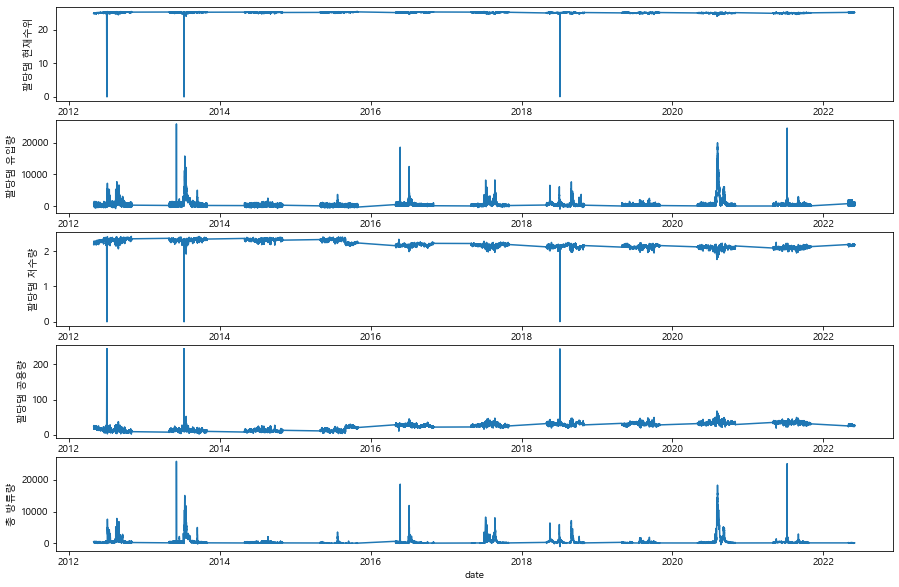

In [16]:
fig,ax = plt.subplots(5,1, figsize = (15,10))
sns.lineplot(train['date'], train['팔당댐 현재수위'], ax = ax[0])
sns.lineplot(train['date'], train['팔당댐 유입량'], ax = ax[1])
sns.lineplot(train['date'], train['팔당댐 저수량'], ax = ax[2])
sns.lineplot(train['date'], train['팔당댐 공용량'], ax = ax[3])
sns.lineplot(train['date'], train['총 방류량'], ax = ax[4])

<AxesSubplot:xlabel='date', ylabel='총 방류량'>

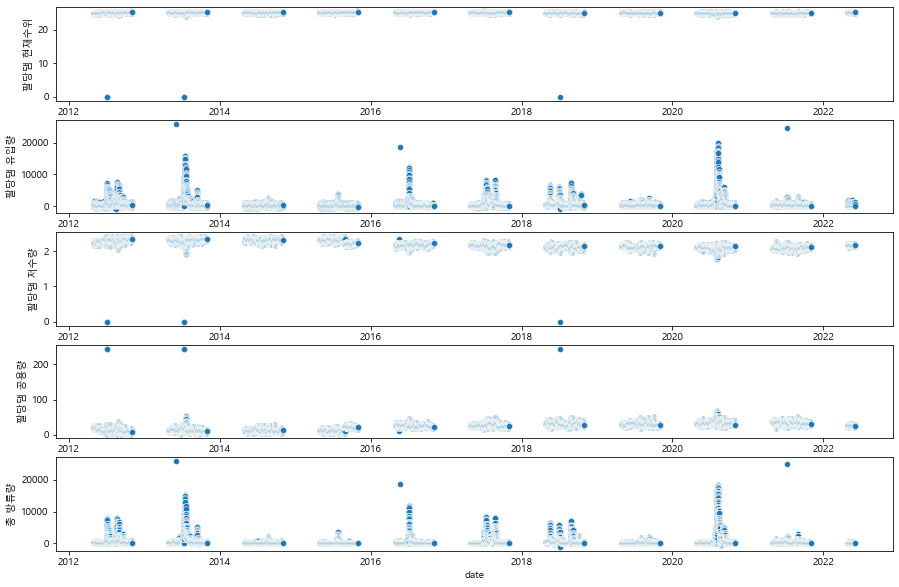

In [17]:
fig,ax = plt.subplots(5,1, figsize = (15,10))
sns.scatterplot(train['date'], train['팔당댐 현재수위'], ax = ax[0])
sns.scatterplot(train['date'], train['팔당댐 유입량'], ax = ax[1])
sns.scatterplot(train['date'], train['팔당댐 저수량'], ax = ax[2])
sns.scatterplot(train['date'], train['팔당댐 공용량'], ax = ax[3])
sns.scatterplot(train['date'], train['총 방류량'], ax = ax[4])

In [18]:
train[train['팔당댐 현재수위']<=0]

,date,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,강화대교 조위,청담대교 수위,청담대교 유량,잠수교 수위,잠수교 유량,한강대교 수위,한강대교 유량,행주대교 수위,행주대교 유량,대곡교 강수량,진관교 강수량,송정동 강수량
9054,2012-07-02 21:00:00,0.0,0.0,0.0000,244.00,0.0,240.0,311.7,476.21,310.2,0.0,299.0,1010.22,284.3,652.89,0.0,0.0,0.0
9060,2012-07-02 22:00:00,0.0,0.0,0.0000,244.00,0.0,176.0,301.7,407.18,299.2,0.0,290.0,326.94,277.3,564.29,0.0,0.0,0.0
9066,2012-07-02 23:00:00,0.0,0.0,0.0000,244.00,0.0,122.0,300.7,400.58,294.2,0.0,283.0,590.88,266.3,438.33,0.0,0.0,0.0
9072,2012-07-03 00:00:00,0.0,0.0,0.0000,244.00,0.0,80.0,295.7,368.42,285.2,0.0,277.0,306.19,268.3,460.03,0.0,0.0,0.0
9078,2012-07-03 01:00:00,0.0,0.0,0.0000,244.00,0.0,158.0,297.7,381.12,286.2,0.0,276.0,184.79,263.3,406.79,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36888,2013-07-12 04:00:00,0.0,0.0,0.0000,244.00,0.0,195.0,405.7,1400.11,379.2,0.0,369.0,2252.24,343.3,1663.48,0.0,0.0,0.0
36894,2013-07-12 05:00:00,0.0,0.0,0.0000,244.00,0.0,290.0,402.7,1362.85,374.2,0.0,365.0,2212.95,340.3,1600.64,0.0,0.0,0.0
36900,2013-07-12 06:00:00,0.0,0.0,0.0000,244.00,0.0,464.0,399.7,1326.12,372.2,0.0,362.0,2144.56,338.3,1559.43,0.0,0.0,0.0
36906,2013-07-12 07:00:00,0.0,0.0,0.0000,244.00,0.0,631.0,396.7,1289.90,370.2,0.0,360.0,2171.14,335.3,1498.64,0.0,0.0,0.0


- 데이터 내에 0인경우와 마이너스인 경우의 이상값이 존재한다.

In [19]:
train[(train['팔당댐 현재수위']<=0) | (train['팔당댐 현재수위'].isna())]

,date,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,강화대교 조위,청담대교 수위,청담대교 유량,잠수교 수위,잠수교 유량,한강대교 수위,한강대교 유량,행주대교 수위,행주대교 유량,대곡교 강수량,진관교 강수량,송정동 강수량
9054,2012-07-02 21:00:00,0.0,0.0,0.0,244.0,0.0,240.0,311.7,476.21,310.2,0.0,299.0,1010.22,284.3,652.89,0.0,0.0,0.0
9060,2012-07-02 22:00:00,0.0,0.0,0.0,244.0,0.0,176.0,301.7,407.18,299.2,0.0,290.0,326.94,277.3,564.29,0.0,0.0,0.0
9066,2012-07-02 23:00:00,0.0,0.0,0.0,244.0,0.0,122.0,300.7,400.58,294.2,0.0,283.0,590.88,266.3,438.33,0.0,0.0,0.0
9072,2012-07-03 00:00:00,0.0,0.0,0.0,244.0,0.0,80.0,295.7,368.42,285.2,0.0,277.0,306.19,268.3,460.03,0.0,0.0,0.0
9078,2012-07-03 01:00:00,0.0,0.0,0.0,244.0,0.0,158.0,297.7,381.12,286.2,0.0,276.0,184.79,263.3,406.79,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261270,2021-10-06 09:00:00,NaN,NaN,NaN,NaN,NaN,407.0,397.7,1301.92,384.2,NaN,384.0,-448.76,336.3,1518.77,0.0,0.0,0.0
261271,2021-10-06 09:10:00,NaN,NaN,NaN,NaN,NaN,390.0,401.7,1350.55,386.2,NaN,385.0,76.48,333.3,1458.80,0.0,1.0,0.0
262598,2021-10-15 14:20:00,NaN,NaN,NaN,NaN,NaN,NaN,271.7,NaN,264.2,NaN,268.0,297.96,255.3,328.54,0.0,0.0,0.0
262599,2021-10-15 14:30:00,NaN,NaN,NaN,NaN,NaN,NaN,271.7,NaN,264.2,NaN,268.0,293.88,256.3,337.86,0.0,0.0,0.0


먼저 팔당댐 데이터 부터 살펴봤을때, 팔당댐 데이터와 총 방류량의 nan값은 모두 같다. 

1. 다른 대교의 수위나 유량으로 유추한다.
2. t-n시점의 데이터를 활용하여 보간한다.

<AxesSubplot:xlabel='팔당댐 유입량', ylabel='총 방류량'>

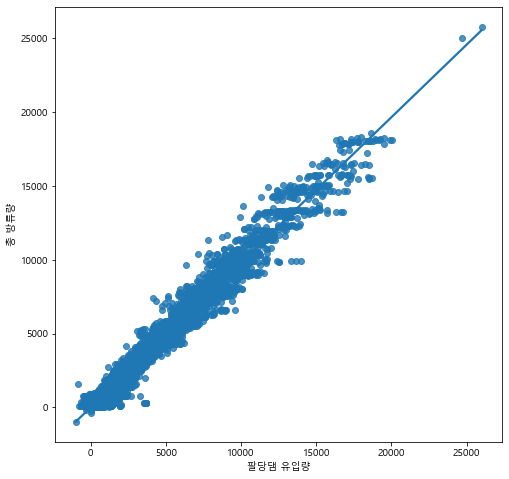

In [20]:
plt.figure(figsize = (8,8))
sns.regplot(data =train, x = '팔당댐 유입량',y = '총 방류량')

<AxesSubplot:>

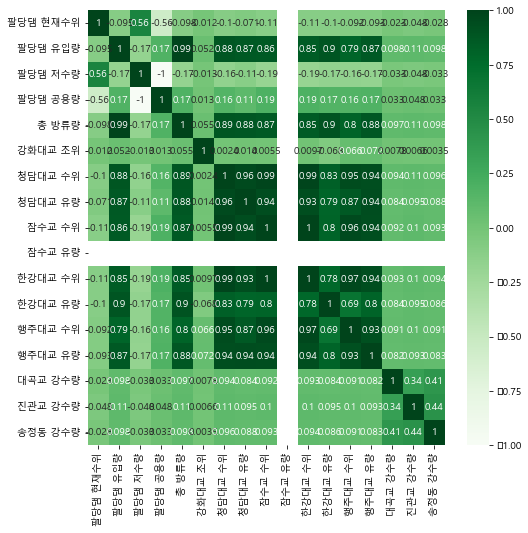

In [21]:
plt.figure(figsize = (8,8))
sns.heatmap(train.corr(),
            annot = True, 
            cmap = 'Greens',
            vmin = -1, vmax = 1)

## 보간

- 유입량과 방류량의 상관관계 99%
- 현재수위와 저수량 74%
- 저수량 공용량 -1%
- 유입량과 각 대교의 수위 80%이상 팔당댐과 가까운 순서대로 89%, 87%, 85%, 80% 유량 역시 비슷한 관계를 보인다.
- 인접 대교 간의 상관관계도 매우 높은것으로 나타난다.

https://ok-lab.tistory.com/189

### 팔당댐 데이터 보간

In [22]:
# 0이하의 값 일괄 nan값으로 변경
for i in list(train.columns[1:6]):
    error_lst = list(train[train[i]<=0][i].index)
    train.loc[error_lst, i] = np.nan

In [23]:
train.isna().sum()

date             0
팔당댐 현재수위       790
팔당댐 유입량      19293
팔당댐 저수량        790
팔당댐 공용량        707
총 방류량         1159
강화대교 조위       4923
청담대교 수위         59
청담대교 유량      15164
잠수교 수위          59
잠수교 유량      189937
한강대교 수위         59
한강대교 유량       1279
행주대교 수위         59
행주대교 유량         59
대곡교 강수량          0
진관교 강수량          0
송정동 강수량          0
dtype: int64

<AxesSubplot:>

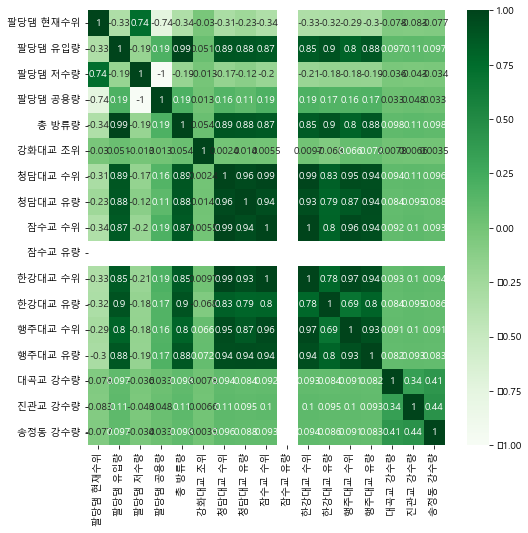

In [24]:
plt.figure(figsize = (8,8))
sns.heatmap(train.corr(),
            annot = True, 
            cmap = 'Greens',
            vmin = -1, vmax = 1)

#### 팔당댐 유입량 보간

In [25]:
# 1. 가장 상관관계가 높은 변수 1개를 통한 예측
# 2. 상관관계가 높은 복수 개의 변수를 통한 예측
# 3, 팔당댐 유입량과 총 방출량에 25000이상의 값은 이상값인가? 정상값인가?

In [26]:
df_2012 = train[train['date'].dt.year == 2012]
df_2012.isna().sum()

date           0
팔당댐 현재수위      69
팔당댐 유입량     1050
팔당댐 저수량       69
팔당댐 공용량        1
총 방류량         90
강화대교 조위      776
청담대교 수위        0
청담대교 유량        0
잠수교 수위         0
잠수교 유량         0
한강대교 수위        0
한강대교 유량        0
행주대교 수위        0
행주대교 유량        0
대곡교 강수량        0
진관교 강수량        0
송정동 강수량        0
dtype: int64

<AxesSubplot:>

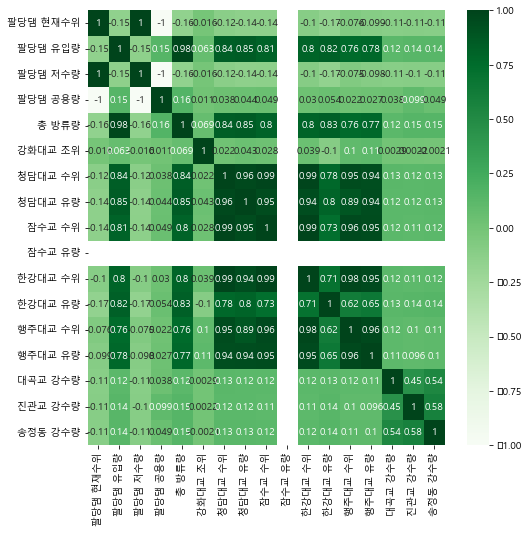

In [27]:
plt.figure(figsize = (8,8))
sns.heatmap(df_2012.corr(),
            annot = True, 
            cmap = 'Greens',
            vmin = -1, vmax = 1)

- 총 방류량은 청담 수위, 청담 유량, 잠수교 수위, 한강대교 수위, 한강대교 유량이 많은 상관관계를 보여 이들로 예측 
- 유입량이 영향을 많이 주지만 방류량이 nan값일때 유입량도 nan값인 경우가 있다.

In [28]:
df_2012.isna().sum()

date           0
팔당댐 현재수위      69
팔당댐 유입량     1050
팔당댐 저수량       69
팔당댐 공용량        1
총 방류량         90
강화대교 조위      776
청담대교 수위        0
청담대교 유량        0
잠수교 수위         0
잠수교 유량         0
한강대교 수위        0
한강대교 유량        0
행주대교 수위        0
행주대교 유량        0
대곡교 강수량        0
진관교 강수량        0
송정동 강수량        0
dtype: int64

In [29]:
df_2012[(df_2012['총 방류량'].isna())&(df_2012['팔당댐 유입량'].isna())&(df_2012['팔당댐 저수량'].isna())&(df_2012['팔당댐 공용량'].isna())]

,date,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,강화대교 조위,청담대교 수위,청담대교 유량,잠수교 수위,잠수교 유량,한강대교 수위,한강대교 유량,행주대교 수위,행주대교 유량,대곡교 강수량,진관교 강수량,송정동 강수량
13200,2012-07-31 16:00:00,NaN,NaN,NaN,NaN,NaN,557.0,297.7,381.12,273.2,0.0,273.0,340.7,256.3,337.86,0.0,0.0,0.0


- 2012년에서는 단 한건의 데이터만 팔당댐에 대한 모든 데이터가 없다. 즉, 이럴때는 다른 아래 데이터들로 유추하는 방법이 필요할것같다.

In [119]:
data2012 = df_2012[(-df_2012['총 방류량'].isna())&(-df_2012['팔당댐 유입량'].isna())&(-df_2012['팔당댐 저수량'].isna())&(-df_2012['팔당댐 공용량'].isna())][['팔당댐 현재수위','팔당댐 저수량','팔당댐 공용량', '총 방류량','팔당댐 유입량']].reset_index(drop = True)
data2012

,팔당댐 현재수위,팔당댐 저수량,팔당댐 공용량,총 방류량,팔당댐 유입량
0,24.800,2.1907,24.93,555.0,555.0
1,24.794,2.1886,25.15,562.9,464.6
2,24.789,2.1869,25.31,576.4,478.1
3,24.789,2.1869,25.31,563.1,464.8
4,24.789,2.1869,25.31,576.4,478.1
...,...,...,...,...,...
25427,25.250,2.3501,8.99,270.2,270.2
25428,25.250,2.3501,8.99,264.1,264.1
25429,25.250,2.3501,8.99,257.9,257.9
25430,25.250,2.3501,8.99,264.1,264.1


In [121]:
scaler = StandardScaler()
scale_data = scaler.fit_transform(data2012)
scale_data =pd.DataFrame(scale_data,columns = data2012.columns)
scale_data 

,팔당댐 현재수위,팔당댐 저수량,팔당댐 공용량,총 방류량,팔당댐 유입량
0,-2.223139,-2.194242,2.194013,-0.158088,-0.172314
1,-2.266564,-2.236809,2.238608,-0.149214,-0.274602
2,-2.302751,-2.271268,2.271040,-0.134049,-0.259327
3,-2.302751,-2.271268,2.271040,-0.148989,-0.274376
4,-2.302751,-2.271268,2.271040,-0.134049,-0.259327
...,...,...,...,...,...
25427,1.033695,1.036825,-1.037059,-0.478014,-0.494568
25428,1.033695,1.036825,-1.037059,-0.484867,-0.501470
25429,1.033695,1.036825,-1.037059,-0.491832,-0.508486
25430,1.033695,1.036825,-1.037059,-0.484867,-0.501470


In [122]:
# 데이터 분리

x_data = scale_data[['팔당댐 현재수위','팔당댐 저수량', '팔당댐 공용량', '총 방류량']]
y_target = scale_data['팔당댐 유입량']

x_train = x_data.iloc[:-5000]
x_test = x_data.iloc[-5000:]
y_train = y_target.iloc[:-5000]
y_test = y_target.iloc[-5000:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((20432, 4), (5000, 4), (20432,), (5000,))

In [123]:
# # 데이터 분리

# x_data = scale_data[['팔당댐 현재수위','팔당댐 저수량', '팔당댐 공용량', '총 방류량']]
# y_target = scale_data['팔당댐 유입량']

# x_train = x_data.iloc[:-5000]
# x_test = x_data.iloc[-5000:]
# y_train = y_target.iloc[:-5000]
# y_test = y_target.iloc[-5000:]
# x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [124]:
rmse_val = [] #to store rmse values for different k
for K in range(200):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(x_train, y_train)  #fit the model
    y_pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,y_pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.28210578491055305
RMSE value for k=  2 is: 0.2387212201428836
RMSE value for k=  3 is: 0.2260391752775097
RMSE value for k=  4 is: 0.21462071718251377
RMSE value for k=  5 is: 0.20678658633047847
RMSE value for k=  6 is: 0.2023146368529556
RMSE value for k=  7 is: 0.20064932193822055
RMSE value for k=  8 is: 0.2006936236287679
RMSE value for k=  9 is: 0.2003203898984466
RMSE value for k=  10 is: 0.19934230497420227
RMSE value for k=  11 is: 0.19824395285969929
RMSE value for k=  12 is: 0.1975649210574694
RMSE value for k=  13 is: 0.19748846763667155
RMSE value for k=  14 is: 0.19777752901581616
RMSE value for k=  15 is: 0.19810199831682185
RMSE value for k=  16 is: 0.19820290959900108
RMSE value for k=  17 is: 0.19718133649914144
RMSE value for k=  18 is: 0.1966712551647181
RMSE value for k=  19 is: 0.19670633607851187
RMSE value for k=  20 is: 0.19642764550182176
RMSE value for k=  21 is: 0.19576817311684572
RMSE value for k=  22 is: 0.19537567071286085
RMSE

RMSE value for k=  180 is: 0.1877732737418671
RMSE value for k=  181 is: 0.187722527474913
RMSE value for k=  182 is: 0.18774058544680383
RMSE value for k=  183 is: 0.18770447708094756
RMSE value for k=  184 is: 0.1877094057641076
RMSE value for k=  185 is: 0.18767186156397653
RMSE value for k=  186 is: 0.1876964824574663
RMSE value for k=  187 is: 0.1876980461592918
RMSE value for k=  188 is: 0.187690180964299
RMSE value for k=  189 is: 0.18773328147145324
RMSE value for k=  190 is: 0.18774785044610368
RMSE value for k=  191 is: 0.1877096550467188
RMSE value for k=  192 is: 0.18775793147672057
RMSE value for k=  193 is: 0.18775532243873233
RMSE value for k=  194 is: 0.18776301040623902
RMSE value for k=  195 is: 0.18779500049662357
RMSE value for k=  196 is: 0.18781039873278885
RMSE value for k=  197 is: 0.18784321639037188
RMSE value for k=  198 is: 0.18785610353641358
RMSE value for k=  199 is: 0.18786139126923249
RMSE value for k=  200 is: 0.18791999009018495


In [68]:
y_new_test = (y_test*np.std(data2012['팔당댐 유입량']))+ np.mean(data2012['팔당댐 유입량'])
y_new_pred = (y_pred*np.std(data2012['팔당댐 유입량']))+ np.mean(data2012['팔당댐 유입량'])

In [97]:
sqrt(mean_squared_error(y_test,y_pred))

0.18791920067312265

In [96]:
sqrt(mean_squared_error(y_new_test,y_new_pred))

166.07820815961483

<AxesSubplot:>

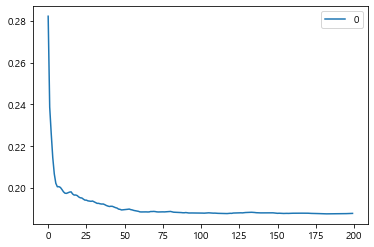

In [126]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

### 강화대교 조위

In [37]:
# plt.figure(figsize = (12,8))
# sns.lineplot(train['ymdhm'], train['tide_level'])

### 대교별 유량

In [38]:
# fig,ax = plt.subplots(4,1,figsize=(15,10))
# sns.lineplot(train['ymdhm'], train['fw_1018662'],ax = ax[0])
# sns.lineplot(train['ymdhm'], train['fw_1018680'],ax = ax[1])
# sns.lineplot(train['ymdhm'], train['fw_1018683'],ax = ax[2])
# sns.lineplot(train['ymdhm'], train['fw_1019630'],ax = ax[3])